## PURE SYSTEM

In [1]:

import pickle
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

# Load the data
df = pd.read_excel("GideonCO2_ML (1).xlsx")

# Filter for Brine System (Ionic Strength ==0)
df_filtered = df[df['Ionic Strength'] == 0]

# Select features and target variable
X = df_filtered[['T (K)', 'P (MPa)', 'Ionic Strength']]
y = df_filtered['Solu(mol/kg)']

# Split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.15, random_state=42)

# Remove outliers with Isolation Forest
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.01, random_state=42)
yhat_iso = iso.fit_predict(X_train)
mask = yhat_iso != -1  # Keep only inliers
X_train_clean = X_train[mask]
y_train_clean = y_train[mask]

# Define pipelines with RandomizedSearchCV for hyperparameter tuning

# Random Forest hyperparameter grid
rf_param_grid = {
    'rf__n_estimators': sp_randint(100, 500),
    'rf__max_depth': sp_randint(10, 40),
    'rf__min_samples_split': sp_randint(2, 10),
    'rf__min_samples_leaf': sp_randint(1, 5)
}

# Gradient Boosting hyperparameter grid
gb_param_grid = {
    'gb__n_estimators': sp_randint(100, 500),
    'gb__learning_rate': uniform(0.01, 0.2),
    'gb__max_depth': sp_randint(3, 10),
    'gb__min_samples_split': sp_randint(2, 10),
    'gb__min_samples_leaf': sp_randint(1, 5)
}


# Random Forest pipeline
rf_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])


# Gradient Boosting pipeline
gb_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('gb', GradientBoostingRegressor(random_state=42))
])

# Set up RandomizedSearchCV for Random Forest
rf_search = RandomizedSearchCV(rf_pipeline, rf_param_grid, n_iter=20, cv=5, scoring='r2', random_state=42, n_jobs=-1)
rf_search.fit(X_train_clean, y_train_clean)
best_rf_pipeline = rf_search.best_estimator_

with open("C:/Users/gyamf/Desktop/keep it up/Optimized/yhup/pure_rf.pkl", "wb") as file:
    pickle.dump(best_rf_pipeline, file)

# Set up RandomizedSearchCV for Gradient Boosting
gb_search = RandomizedSearchCV(gb_pipeline, gb_param_grid, n_iter=20, cv=5, scoring='r2', random_state=42, n_jobs=-1)
gb_search.fit(X_train_clean, y_train_clean)
best_gb_pipeline = gb_search.best_estimator_

with open("C:/Users/gyamf/Desktop/keep it up/Optimized/yhup/pure_gb.pkl", "wb") as file:
    pickle.dump(best_gb_pipeline, file)

# Predict solubility for the entire dataset using the best models
y_pred_rf_full = best_rf_pipeline.predict(X)
y_pred_gb_full = best_gb_pipeline.predict(X)



'''with open("C:/Users/gyamf/Desktop/keep it up/Optimized/yhup/pure_rf.pkl", "wb") as file:
    pickle.dump(y_pred_rf_full, file)
    
with open("C:/Users/gyamf/Desktop/keep it up/Optimized/yhup/pure_gb.pkl", "wb") as file:
    pickle.dump(y_pred_gb_full, file)'''

# Combine predictions by averaging for ensembling
y_pred_ensemble = (y_pred_rf_full + y_pred_gb_full) / 2

# Add predictions to DataFrame for comparison
df_filtered['Predicted Solu(mol/kg) - RF'] = y_pred_rf_full
df_filtered['Predicted Solu(mol/kg) - GB'] = y_pred_gb_full
df_filtered['Predicted Solu(mol/kg) - Ensemble'] = y_pred_ensemble

# Calculate R-squared values for the entire dataset
r2_rf_full = r2_score(y, y_pred_rf_full)
r2_gb_full = r2_score(y, y_pred_gb_full)
r2_ensemble_full = r2_score(y, y_pred_ensemble)







C:\Users\gyamf\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\gyamf\AppData\Local\Temp\ipykernel_28864\1560809741.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Predicted Solu(mol/kg) - RF'] = y_pred_rf_full
C:\Users\gyamf\AppData\Local\Temp\ipykernel_28864\1560809741.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Predicted Solu(mol/kg) - GB'

Preprocessing steps for Pure system saved as preprocessing_pure.pkl


Enter the pressure P (MPa):  0.1
Enter the temperature T (K):  333
Enter the Ionic Strength:  0



Predicted Solubility (Solu(mol/kg)):
Random Forest Prediction: 0.0162 mol/kg
Gradient Boosting Prediction: 0.0132 mol/kg
Ensemble Prediction: 0.0147 mol/kg



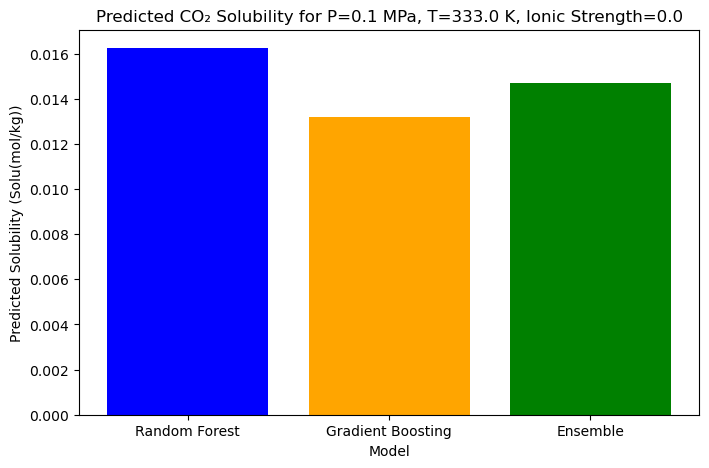

In [2]:






from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# Function to interactively predict solubility based on user inputs
def predict_interactive():
    # Prompt the user for input values
    try:
        P = float(input("Enter the pressure P (MPa): "))
        T = float(input("Enter the temperature T (K): "))
        ionic_strength = float(input("Enter the Ionic Strength: "))
    except ValueError:
        print("Please enter valid numeric values for P, T, and Ionic Strength.")
        return
    
    # Create a DataFrame for the new input data
    new_data = pd.DataFrame({
        'T (K)': [T],
        'P (MPa)': [P],
        'Ionic Strength': [ionic_strength]
    })
    
    # Use the trained models to predict solubility
    rf_prediction = best_rf_pipeline.predict(new_data)[0]
    gb_prediction = best_gb_pipeline.predict(new_data)[0]
    ensemble_prediction = (rf_prediction + gb_prediction) / 2

   


    
    
    # Print the predictions
    print(f"\nPredicted Solubility (Solu(mol/kg)):")
    print(f"Random Forest Prediction: {rf_prediction:.4f} mol/kg")
    print(f"Gradient Boosting Prediction: {gb_prediction:.4f} mol/kg")
    print(f"Ensemble Prediction: {ensemble_prediction:.4f} mol/kg\n")
    
    # Plot the predictions
    models = ['Random Forest', 'Gradient Boosting', 'Ensemble']
    predictions = [rf_prediction, gb_prediction, ensemble_prediction]
    
    plt.figure(figsize=(8, 5))
    plt.bar(models, predictions, color=['blue', 'orange', 'green'])
    plt.xlabel('Model')
    plt.ylabel('Predicted Solubility (Solu(mol/kg))')
    plt.title(f'Predicted CO₂ Solubility for P={P} MPa, T={T} K, Ionic Strength={ionic_strength}')
    plt.show()

# Run the interactive prediction function
predict_interactive()
